In [1]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/Bayesian-Filtering-and-Smoothing


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Tuple

In [3]:
from regression.linear_regression import *

In [4]:
from mcmc.utils.mcmc_utils import *

# Linear Gaussian Regression  
## Batch and Recursive Bayesian Inference

This notebook accompanies the report *Linear Gaussian Regression: Batch and Recursive Inference*.  
It reproduces the results numerically while mirroring the mathematical structure of the Bayesian linear–Gaussian model.

The goal is to:
- Formulate linear regression as a joint Gaussian model
- Derive batch posterior inference via Gaussian conditioning
- Derive recursive (online) Bayesian updates
- Demonstrate equivalence between batch and recursive inference


## Observation Model

We consider a linear regression model with additive Gaussian noise.

At observation time $t_k \in \mathbb{R}$, the measurement is

$$
y_k = \theta_1 + \theta_2 t_k + \eta_k,
\quad
\eta_k \sim \mathcal{N}(0, \sigma^2).
$$

The unknown parameter vector is

$$
\theta =
\begin{bmatrix}
\theta_1 \\
\theta_2
\end{bmatrix}
\in \mathbb{R}^2.
$$


## Stacked Linear Model

Collecting $n$ observations, define

$$
Y =
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix},
\quad
H =
\begin{bmatrix}
1 & t_1 \\
1 & t_2 \\
\vdots & \vdots \\
1 & t_n
\end{bmatrix}.
$$

The linear observation model becomes

$$
Y = H\theta + \eta,
\quad
\eta \sim \mathcal{N}(0, \sigma^2 I_n).
$$


## Bayesian Prior on Parameters

We treat the regression parameters as random variables.

A Gaussian prior is placed on $\theta$:

$$
\theta \sim \mathcal{N}(\mu_0, C_0).
$$

Conditioned on $\theta$, the likelihood is

$$
Y \mid \theta \sim \mathcal{N}(H\theta, \sigma^2 I_n).
$$


## Joint Gaussian Formulation

Define the joint random vector

$$
Z =
\begin{bmatrix}
\theta \\
Y
\end{bmatrix}.
$$

Since $Y = H\theta + \eta$ is an affine function of Gaussian variables,
the joint vector $Z$ is Gaussian.

Once the joint mean and covariance are known,
posterior and predictive distributions follow by Gaussian conditioning.


## Joint Mean

From the observation model,

$$
\mathbb{E}[Y \mid \theta] = H\theta.
$$

Applying the law of total expectation,

$$
\mathbb{E}[Y] = H \mathbb{E}[\theta] = H\mu_0.
$$

Thus, the joint mean is

$$
\mathbb{E}[Z] =
\begin{bmatrix}
\mu_0 \\
H\mu_0
\end{bmatrix}.
$$


## Joint Covariance Structure

The covariance of $Z$ has block form

$$
\mathrm{Cov}(Z) =
\begin{bmatrix}
\mathrm{Var}(\theta) & \mathrm{Cov}(\theta, Y) \\
\mathrm{Cov}(Y, \theta) & \mathrm{Var}(Y)
\end{bmatrix}.
$$


### Parameter Covariance

$$
\mathrm{Var}(\theta) = C_0.
$$


### Cross-Covariance

$$
\mathrm{Cov}(\theta, Y)
= \mathrm{Cov}(\theta, H\theta + \eta)
= C_0 H^\top.
$$


### Observation Covariance

Using the law of total variance,

$$
\mathrm{Var}(Y)
= H C_0 H^\top + \sigma^2 I_n.
$$


## Final Joint Distribution

The joint distribution is

$$
\begin{bmatrix}
\theta \\
Y
\end{bmatrix}
\sim
\mathcal{N}
\left(
\begin{bmatrix}
\mu_0 \\
H\mu_0
\end{bmatrix},
\begin{bmatrix}
C_0 & C_0 H^\top \\
H C_0 & H C_0 H^\top + \sigma^2 I_n
\end{bmatrix}
\right).
$$


## Generate Data

In [5]:
noise_std = 1e-1
true_theta_1 = 1.0
true_theta_2 = 0.7
dataset = generate_RegressionDataSet(
    num_data=50, 
    theta_1=true_theta_1, 
    theta_2=true_theta_2, 
    noise_std=noise_std)

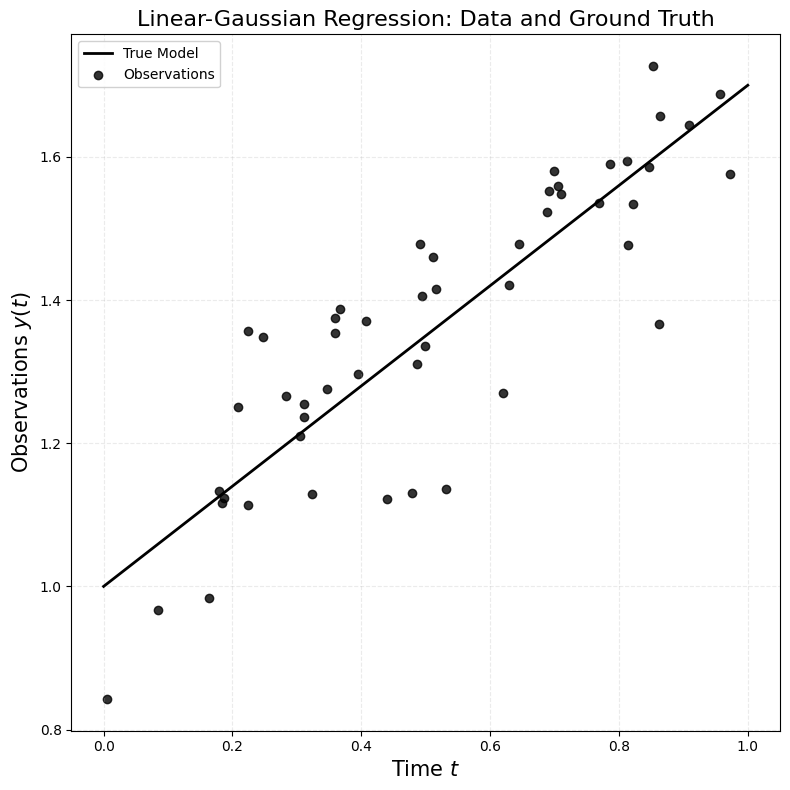

In [6]:
fig = plt.figure(1, figsize=(8,8))

plt.plot(
    dataset.t_plot, 
    dataset.y_true, 
    linestyle="-", 
    color="black", 
    linewidth=2, 
    label='True Model')

plt.scatter(
    dataset.t, 
    dataset.y, 
    color = "black",
    alpha = 0.8,
    label="Observations")

plt.xlabel(r"Time $t$", fontsize=15)
plt.ylabel(r"Observations $y(t)$", fontsize=15)

plt.title(
    "Linear-Gaussian Regression: Data and Ground Truth",
    fontsize=16
)

plt.legend(
    loc="best",
    frameon=True,
    framealpha=0.9
)

plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
save_path_1 = os.path.join(ROOT, "images/regression/data_ground_truth.png")
plt.savefig(save_path_1)
plt.show()
plt.close(fig)

## Prior on model parameters

We place independent standard Gaussian priors on the regression parameters
$\theta_1$ (intercept) and $\theta_2$ (slope):

$$
\theta_1 \sim \mathcal{N}(0, 1), \qquad
\theta_2 \sim \mathcal{N}(0, 1).
$$

Equivalently, the parameter vector

$$
\boldsymbol{\theta} =
\begin{bmatrix}
\theta_1 \\
\theta_2
\end{bmatrix}
$$

is assigned a multivariate Gaussian prior

$$
\boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{\mu}_0, \mathbf{C}_0),
$$

with

$$
\boldsymbol{\mu}_0 =
\begin{bmatrix}
0 \\
0
\end{bmatrix},
\qquad
\mathbf{C}_0 =
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}.
$$


<Figure size 640x480 with 0 Axes>

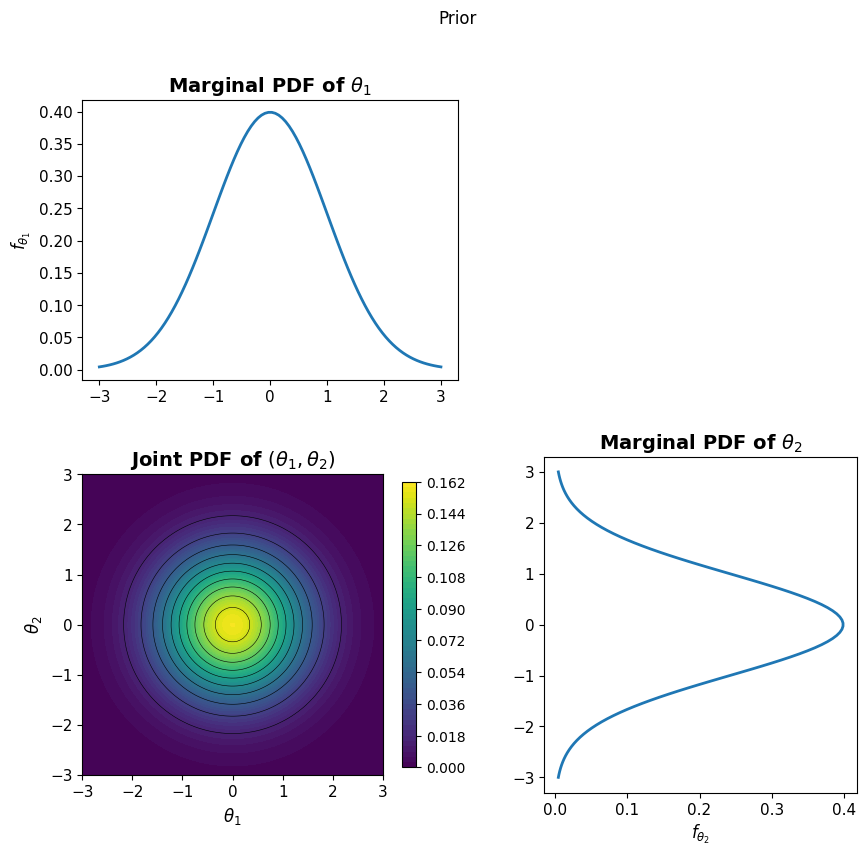

In [7]:
# Prior on parameters
mu_0 = np.zeros(2)          # Prior Mean of theta
C_0 = np.eye(2)             # Prior Co-variance of theta

offset_range = np.linspace(-3, 3,100)
slope_range = np.linspace(-3, 3,100)

plt.close("all")
plt.figure(1)
figp, axsp = plot_bivariate_gauss(offset_range, slope_range, mu_0, C_0)
plt.suptitle('Prior')
save_path_2 = os.path.join(ROOT, "images/regression/prior_parameters.png")
plt.savefig(save_path_2)
plt.show()

## Prior Predictive Distribution

The latent regression function is

$$
f(t) = \theta_1 + \theta_2 t.
$$

Evaluated on a grid of inputs,

$$
f = H_p \theta.
$$

Since $\theta$ is Gaussian,

$$
f \sim \mathcal{N}(H_p \mu_0, H_p C_0 H_p^\top).
$$


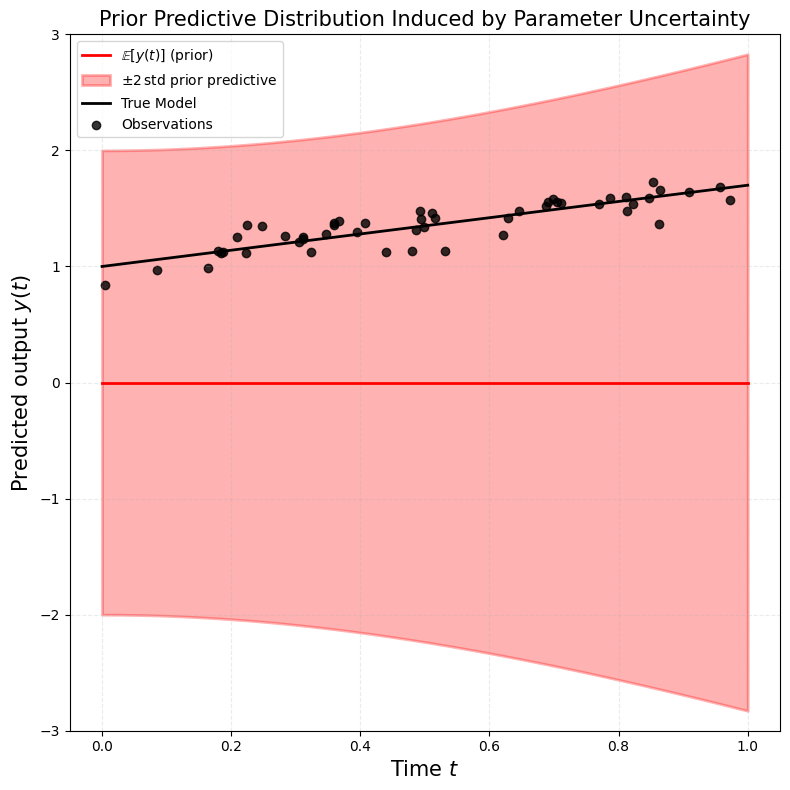

In [8]:
# Plotting Grid
t_plot = dataset.t_plot     # shape (m,)
m = t_plot.shape[0]

# Design matrix H_p for plotting points
H_p = np.column_stack([
    np.ones_like(t_plot), t_plot
    ])                      # shape (m, 2)


# Prior Predictive mean
prior_mean = H_p @ mu_0       # shape (m,)

# Prior Predictive Covariance
prior_co_var = H_p @ C_0 @ H_p.T # shape (m,m)

# Prior Predictive Variance
prior_var = np.diag(prior_co_var) # shape (m,)
prior_std = np.sqrt(prior_var)

# Plot
fig = plt.figure(figsize=(8, 8))

plt.plot(
    t_plot,
    prior_mean,
    color="red",
    linewidth=2,
    label=r"$\mathbb{E}[y(t)]$ (prior)"
)

plt.fill_between(
    t_plot,
    prior_mean - 2 * prior_std,
    prior_mean + 2 * prior_std,
    color="red",
    linewidth=2,
    alpha=0.3,
    label=r"$\pm 2\,\mathrm{std}$ prior predictive"
)

plt.plot(
    dataset.t_plot, 
    dataset.y_true, 
    linestyle="-", 
    color="black", 
    linewidth=2, 
    label='True Model')

plt.scatter(
    dataset.t, 
    dataset.y, 
    color = "black",
    alpha = 0.8,
    label="Observations")

plt.xlabel(r"Time $t$", fontsize=15)
plt.ylabel(r"Predicted output $y(t)$", fontsize=15)
plt.ylim([-3,3])
plt.title("Prior Predictive Distribution Induced by Parameter Uncertainty", fontsize=15)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
save_path_3 = os.path.join(ROOT, "images/regression/prior_predictive.png")
plt.savefig(save_path_3)
plt.show()
plt.close(fig)

## Batch Posterior Inference

Conditioning on observed data $Y = y$,

$$
\theta \mid Y = y \sim \mathcal{N}(\mu_{\text{post}}, C_{\text{post}}).
$$

The posterior mean is

$$
\mu_{\text{post}}
= \mu_0
+ C_0 H^\top
(H C_0 H^\top + \sigma^2 I_n)^{-1}
(y - H\mu_0).
$$

The posterior covariance is

$$
C_{\text{post}}
= C_0
- C_0 H^\top
(H C_0 H^\top + \sigma^2 I_n)^{-1}
H C_0.
$$


In [9]:
t = dataset.t   # shape (n,)
y = dataset.y   # shape (n,)
n = t.shape[0]


# Design matrix H for Observation points
H = np.column_stack([
    np.ones_like(t), t
    ])                      # shape (m, 2)

mu_post, C_post = batch_linear_gaussian_update(
    y=y, 
    H=H, 
    mu_0=mu_0, 
    C_0=C_0, 
    noise_std=noise_std)

In [10]:
print("posterior mean = ", mu_post)
print("prosterior Co-Variance = ", C_post)

posterior mean =  [1.01271635 0.6821718 ]
prosterior Co-Variance =  [[ 0.0010068  -0.00157741]
 [-0.00157741  0.00308391]]


<Figure size 640x480 with 0 Axes>

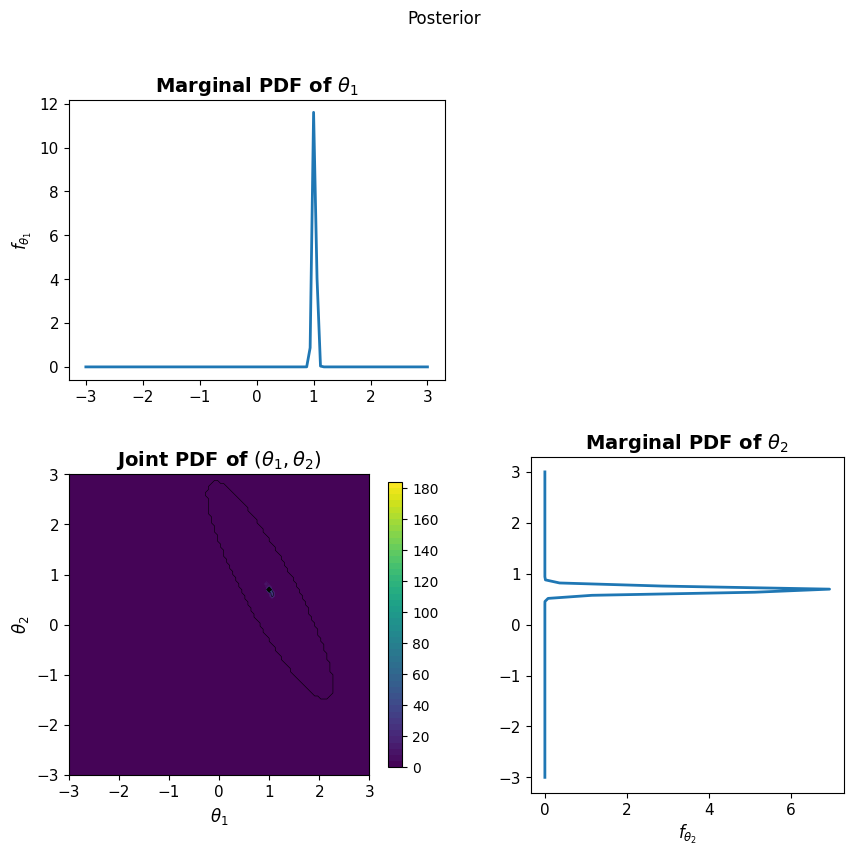

In [14]:
# Posterior on parameters

offset_range = np.linspace(-3, 3,100)
slope_range = np.linspace(-3, 3,100)

plt.close("all")
plt.figure(2)
figp, axsp = plot_bivariate_gauss(offset_range, slope_range, mu_post, C_post)
plt.suptitle('Posterior')
save_path_4 = os.path.join(ROOT, "images/regression/posterior_parameters.png")
plt.savefig(save_path_4)
plt.show()

## Posterior Predictive Distribution

For an input $t$, define

$$
H(t) = [1 \quad t].
$$

The posterior predictive distribution is

$$
f(t) \mid Y
\sim
\mathcal{N}
\left(
H(t)\mu_{\text{post}},
\;
H(t) C_{\text{post}} H(t)^\top
\right).
$$


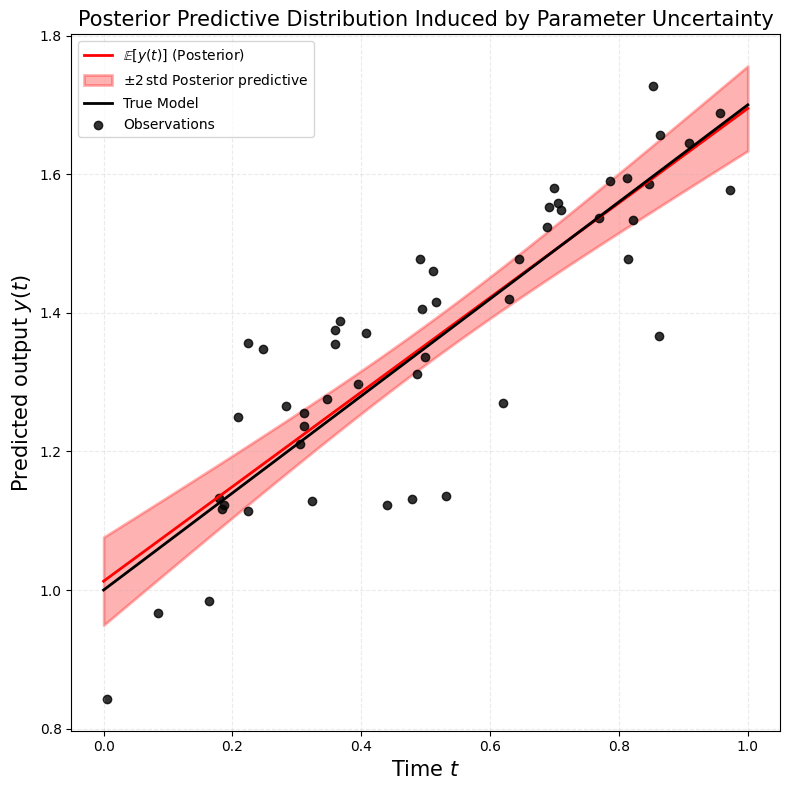

In [15]:
# Plotting Grid
t_plot = dataset.t_plot     # shape (m,)
m = t_plot.shape[0]

# Design matrix H_p for plotting points
H_p = np.column_stack([
    np.ones_like(t_plot), t_plot
    ])                      # shape (m, 2)


# Posterior Predictive mean
posterior_mean = H_p @ mu_post       # shape (m,)

# Posterior Predictive Covariance
prosterior_co_var = H_p @ C_post @ H_p.T # shape (m,m)

# Posterior Predictive Variance
Posterior_var = np.diag(prosterior_co_var) # shape (m,)
Posterior_std = np.sqrt(Posterior_var)

# Plot
fig = plt.figure(figsize=(8, 8))

plt.plot(
    t_plot,
    posterior_mean,
    color="red",
    linewidth=2,
    label=r"$\mathbb{E}[y(t)]$ (Posterior)"
)

plt.fill_between(
    t_plot,
    posterior_mean - 2 * Posterior_std,
    posterior_mean + 2 * Posterior_std,
    color="red",
    linewidth=2,
    alpha=0.3,
    label=r"$\pm 2\,\mathrm{std}$ Posterior predictive"
)

plt.plot(
    dataset.t_plot, 
    dataset.y_true, 
    linestyle="-", 
    color="black", 
    linewidth=2, 
    label='True Model')

plt.scatter(
    dataset.t, 
    dataset.y, 
    color = "black",
    alpha = 0.8,
    label="Observations")

plt.xlabel(r"Time $t$", fontsize=15)
plt.ylabel(r"Predicted output $y(t)$", fontsize=15)
plt.title("Posterior Predictive Distribution Induced by Parameter Uncertainty", fontsize=15)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
save_path_5 = os.path.join(ROOT, "images/regression/posterior_predictive.png")
plt.savefig(save_path_5)
plt.show()
plt.close(fig)

## Recursive Bayesian Linear Regression

Observations can be assimilated sequentially.

At time $n$,

$$
y_n = H_n \theta + \eta_n,
\quad
H_n = [1 \quad t_n].
$$

Assume

$$
\theta \mid Y_{1:n-1} \sim \mathcal{N}(\mu_{n-1}, C_{n-1}).
$$


### Recursive Update Equations

Define

$$
S_n = H_n C_{n-1} H_n^\top + \sigma^2,
$$

$$
K_n = C_{n-1} H_n^\top S_n^{-1}.
$$

The recursive updates are

$$
\mu_n = \mu_{n-1} + K_n (y_n - H_n \mu_{n-1}),
$$

$$
C_n = C_{n-1} - K_n H_n C_{n-1}.
$$


Step 10, posterior mean = [0.84065988 1.64952709]


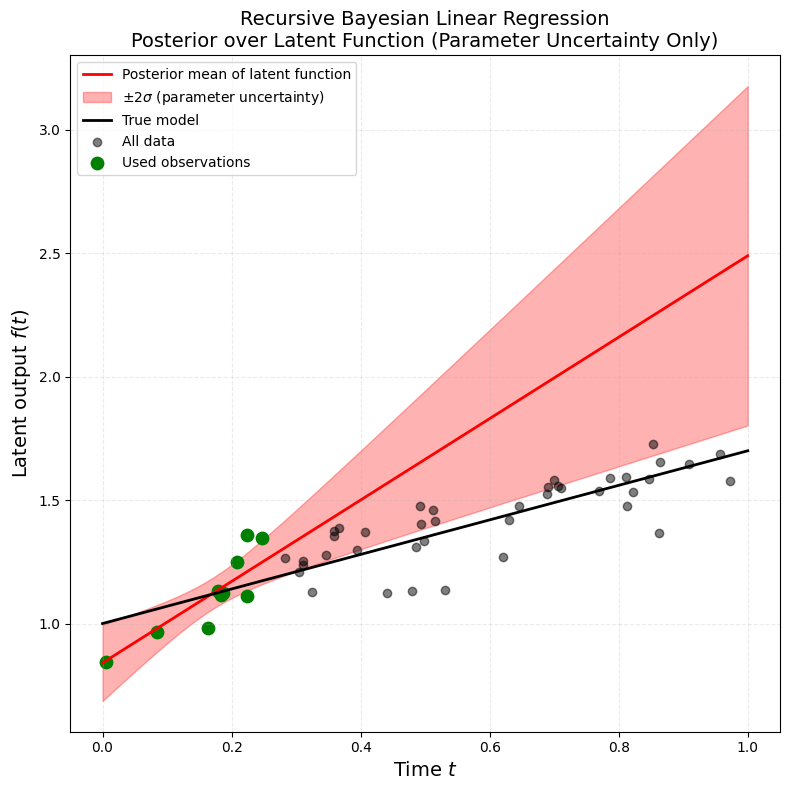

Step 20, posterior mean = [0.90447452 1.16840371]


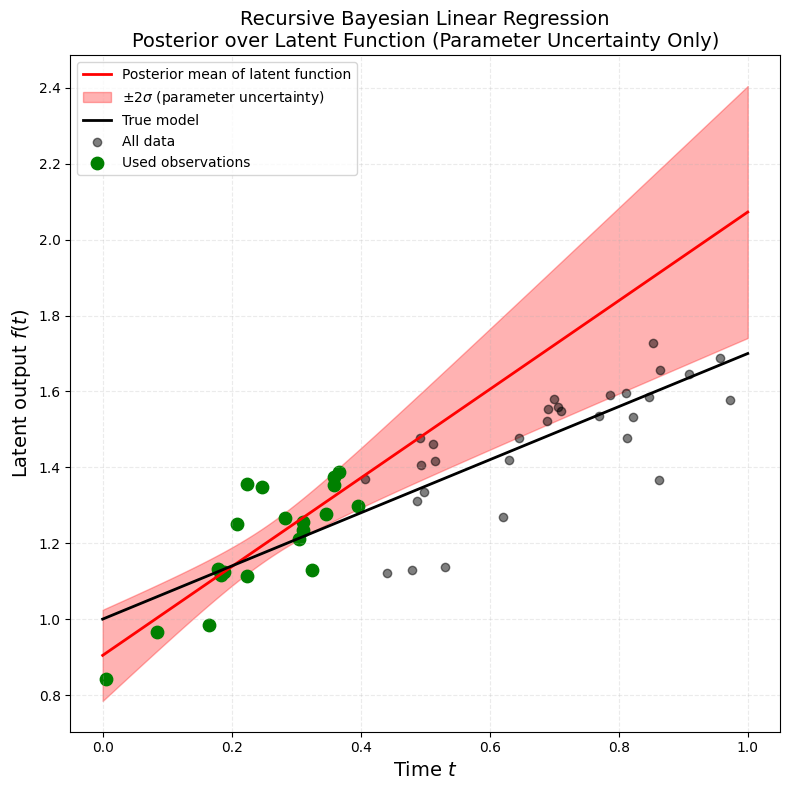

Step 30, posterior mean = [0.99484685 0.7386798 ]


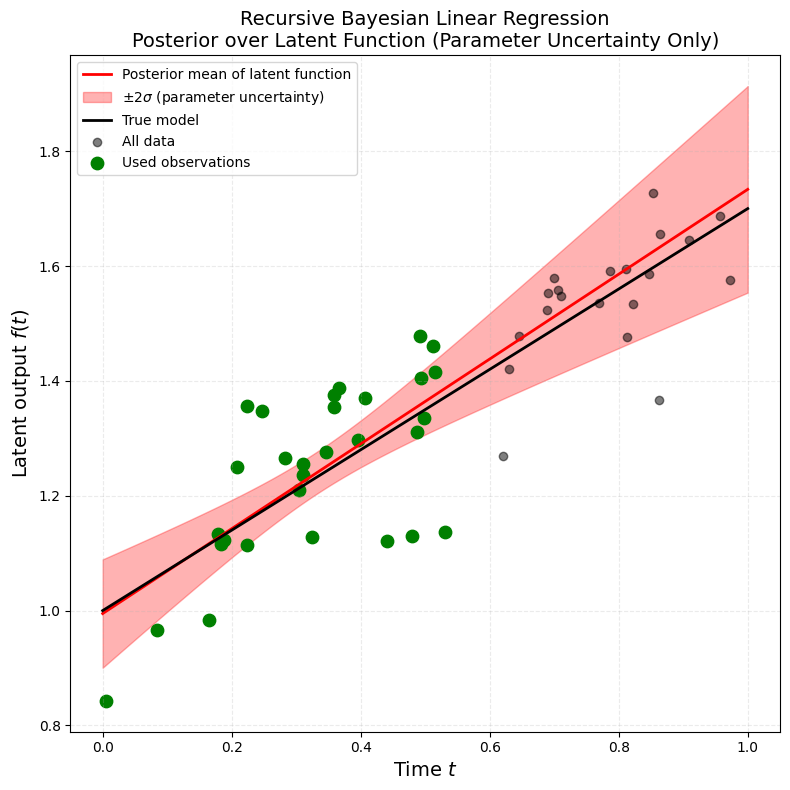

Step 40, posterior mean = [0.99153681 0.74533983]


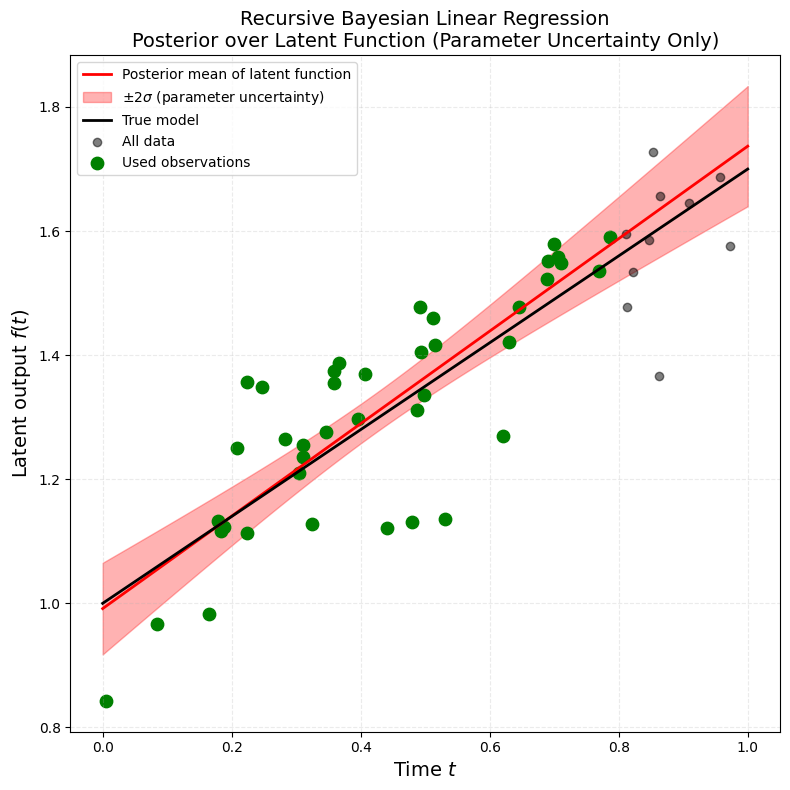

Step 50, posterior mean = [1.01271635 0.6821718 ]


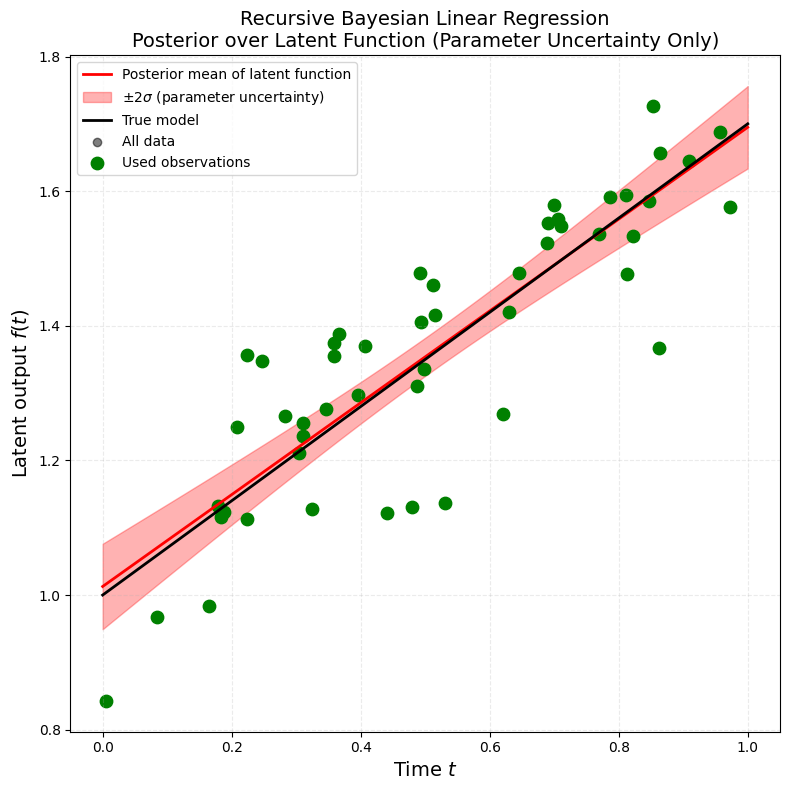

In [18]:
# --------------------------------------------------
# Initialization
# --------------------------------------------------

updated_mean = mu_0.copy()          # (2,)
updated_covariance = C_0.copy()     # (2,2)

d = updated_mean.shape[0]
num_data = dataset.t.shape[0]

# Store parameter mean history (optional)
means = np.zeros((num_data + 1, d))
means[0] = updated_mean

fignum = 5

# --------------------------------------------------
# Design matrix for latent function plotting
# f(t) = [1 t] theta
# --------------------------------------------------

H_p = np.column_stack([
    np.ones_like(t_plot),
    t_plot
])                                   # (m, 2)

# --------------------------------------------------
# Recursive updates
# --------------------------------------------------

for ii in range(1, num_data + 1):

    # --------------------------------------------------
    # New observation
    # --------------------------------------------------
    y_k = np.array([dataset.y[ii - 1]])          # (1,)
    H_k = np.array([[1.0, dataset.t[ii - 1]]])   # (1,2)

    # --------------------------------------------------
    # Bayesian linear Gaussian update
    # --------------------------------------------------
    updated_mean, updated_covariance = batch_linear_gaussian_update(
        y_k,
        H_k,
        updated_mean,
        updated_covariance,
        noise_std
    )

    means[ii] = updated_mean

    # --------------------------------------------------
    # Plot every 10 steps
    # --------------------------------------------------
    if ii % 10 == 0 or ii == num_data:

        print(f"Step {ii}, posterior mean = {updated_mean}")

        plt.close(fignum)
        fig = plt.figure(fignum, figsize=(8, 8))

        # ----------------------------------------------
        # Latent function posterior
        # f(t) = H_p * theta
        # ----------------------------------------------
        latent_mean = H_p @ updated_mean
        latent_cov  = H_p @ updated_covariance @ H_p.T
        latent_std  = np.sqrt(np.diag(latent_cov))

        # Posterior mean of latent function
        plt.plot(
            t_plot,
            latent_mean,
            color="red",
            linewidth=2,
            label="Posterior mean of latent function"
        )

        # Parameter-induced uncertainty
        plt.fill_between(
            t_plot,
            latent_mean - 2 * latent_std,
            latent_mean + 2 * latent_std,
            color="red",
            alpha=0.3,
            label=r"$\pm 2\sigma$ (parameter uncertainty)"
        )

        # True model
        plt.plot(
            dataset.t_plot,
            dataset.y_true,
            color="black",
            linewidth=2,
            label="True model"
        )

        # Observations NOT used yet
        plt.scatter(
            dataset.t[ii:],
            dataset.y[ii:],
            color="black",
            alpha=0.5,
            label="All data"
        )

        # Observations used so far
        plt.scatter(
            dataset.t[:ii],
            dataset.y[:ii],
            color="green",
            s=80,
            label="Used observations"
        )

        plt.xlabel(r"Time $t$", fontsize=14)
        plt.ylabel(r"Latent output $f(t)$", fontsize=14)
        plt.title(
            "Recursive Bayesian Linear Regression\n"
            "Posterior over Latent Function (Parameter Uncertainty Only)",
            fontsize=14
        )

        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.25)
        plt.tight_layout()
        plot_name = "recursive_posterior_" + str(ii) + ".png"
        save_path_6 = os.path.join(ROOT, "images/regression/", plot_name)
        plt.savefig(save_path_6)
        plt.show()
        plt.close(fig)


## Batch vs Recursive Equivalence

After all observations are processed,

$$
\mu_n \rightarrow \mu_{\text{batch}},
\quad
C_n \rightarrow C_{\text{batch}}.
$$

Recursive Bayesian linear regression performs exact inference
and is algebraically equivalent to batch Bayesian regression.

This equivalence is the foundation of Kalman filtering.


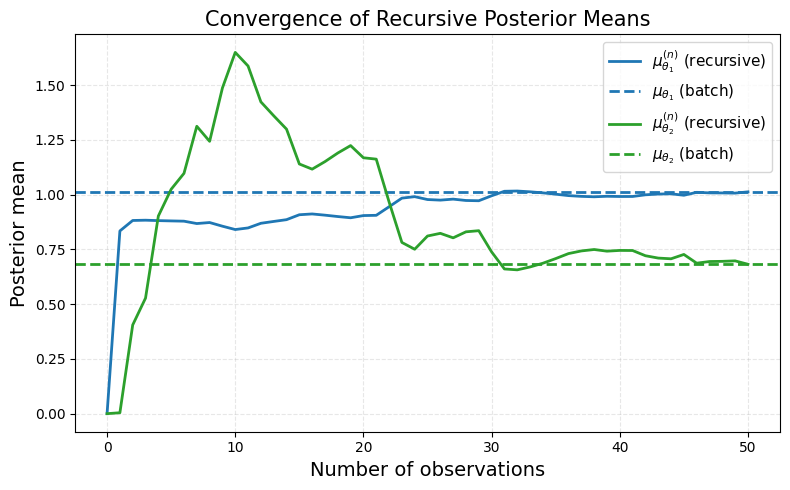

In [21]:
means = np.asarray(means)
num_steps = means.shape[0]
steps = np.arange(num_steps)

plt.figure(figsize=(8, 5))

# θ1 (intercept)
plt.plot(
    steps,
    means[:, 0],
    color="tab:blue",
    linewidth=2,
    label=r"$\mu_{\theta_1}^{(n)}$ (recursive)"
)
plt.axhline(
    y=mu_post[0],
    color="tab:blue",
    linestyle="--",
    linewidth=2,
    label=r"$\mu_{\theta_1}$ (batch)"
)

# θ2 (slope)
plt.plot(
    steps,
    means[:, 1],
    color="tab:green",
    linewidth=2,
    label=r"$\mu_{\theta_2}^{(n)}$ (recursive)"
)
plt.axhline(
    y=mu_post[1],
    color="tab:green",
    linestyle="--",
    linewidth=2,
    label=r"$\mu_{\theta_2}$ (batch)"
)

plt.xlabel("Number of observations", fontsize=14)
plt.ylabel("Posterior mean", fontsize=14)
plt.title("Convergence of Recursive Posterior Means", fontsize=15)

plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=11, loc="best")
plt.tight_layout()
save_path_7 = os.path.join(ROOT, "images/regression/recursive_vs_batch_means.png")
plt.savefig(save_path_7)
plt.show()
